<a href="https://colab.research.google.com/github/naralakamsani/unsupervised_learning/blob/main/bike_sharing_demand_unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
from google.colab import drive

from collections import defaultdict

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, learning_curve, validation_curve, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.manifold import LocallyLinearEmbedding, Isomap

from sklearn.neural_network import MLPRegressor

from scipy.stats import kurtosis
from sklearn.metrics import classification_report, f1_score, silhouette_score, mean_squared_error
import matplotlib.pyplot as plt

import time

#Data

[Bike Sharing Demand](https://www.kaggle.com/competitions/bike-sharing-demand/overview)


##Load Data

In [2]:
!curl -o bike_sharing_demand.csv https://raw.githubusercontent.com/naralakamsani/supervised_learning/main/data/bike_sharing/train.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  633k  100  633k    0     0  1550k      0 --:--:-- --:--:-- --:--:-- 1551k


In [3]:
df = pd.read_csv("bike_sharing_demand.csv")

In [4]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## Encode Labeled Data

In [5]:
df["datetime"] = pd.to_datetime(df["datetime"])

df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['weekday_name'] = df['datetime'].dt.weekday

df = df.drop(columns=["datetime", "casual","registered","holiday"])

In [6]:
df.head()

,season,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,weekday_name
0,1,0,1,9.84,14.395,81,0.0,16,2011,1,1,0,5
1,1,0,1,9.02,13.635,80,0.0,40,2011,1,1,1,5
2,1,0,1,9.02,13.635,80,0.0,32,2011,1,1,2,5
3,1,0,1,9.84,14.395,75,0.0,13,2011,1,1,3,5
4,1,0,1,9.84,14.395,75,0.0,1,2011,1,1,4,5


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season        10886 non-null  int64  
 1   workingday    10886 non-null  int64  
 2   weather       10886 non-null  int64  
 3   temp          10886 non-null  float64
 4   atemp         10886 non-null  float64
 5   humidity      10886 non-null  int64  
 6   windspeed     10886 non-null  float64
 7   count         10886 non-null  int64  
 8   year          10886 non-null  int64  
 9   month         10886 non-null  int64  
 10  day           10886 non-null  int64  
 11  hour          10886 non-null  int64  
 12  weekday_name  10886 non-null  int64  
dtypes: float64(3), int64(10)
memory usage: 1.1 MB


## Split Data

In [8]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['count'],axis=1), df['count'], test_size=0.2, random_state=1)

In [9]:
print("Train data size:", len(x_train))
print("Test data size:", len(x_test))

Train data size: 8708
Test data size: 2178


## Scale Data

In [10]:
x_train_not_scaled = x_train
x_test_not_scaled = x_test

scaler =  StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.fit_transform(x_test), columns=x_test.columns)

In [11]:
x_train.head()

,season,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,weekday_name
0,0.441703,0.686255,0.906197,0.990915,0.971847,1.406609,0.875327,-1.003912,0.427886,-1.085004,-0.797314,-0.010314
1,-1.353141,-1.457184,0.906197,0.567489,0.881658,-0.463818,0.509680,-1.003912,-1.024986,1.646535,-1.664684,0.987621
2,0.441703,0.686255,-0.665748,0.567489,0.432493,1.354653,0.509680,-1.003912,0.427886,0.918125,-0.652752,-1.507217
3,-0.455719,0.686255,-0.665748,-0.067649,-0.017266,0.263570,-0.464832,0.996103,-0.443837,1.464433,-1.375561,0.488654
4,-1.353141,-1.457184,-0.665748,-1.337927,-1.095974,0.679221,-1.560954,0.996103,-1.315560,-1.085004,-1.230999,0.987621


# Plots

## k-means

In [12]:
def plot_km(title, datasets, dataset_labels, k_range=range(2,13), metric="Distortion"):

  if metric not in ["Distortion", "Silhouette Score"]:
    print("Invalid Metric: Use Distortion or Silhouette Score")

  plt.figure()
  plt.title(title)

  plt.grid(True)

  plt.xlabel("Number of clusters")
  plt.ylabel(metric)


  for x,label in zip(datasets, dataset_labels):
    scores = []

    for k in k_range:
          km_model = KMeans(n_clusters=k, n_init='auto', random_state=0)
          km_model.fit(x)
          if metric == "Distortion":
            score = km_model.inertia_
          elif metric == "Silhouette Score":
            score = silhouette_score(x, km_model.labels_)

          scores.append(score)

    plt.plot(k_range, scores, 'o-', label=label)

  plt.legend(loc="best")

  return plt

## Expectation Maximization

In [13]:
def plot_em(title, datasets, dataset_labels, components_range=range(1,13)):
  plt.figure()
  plt.title(title)

  plt.xlabel("Number of clusters")
  plt.ylabel("BIC Score")

  plt.grid(True)

  for x,label in zip(datasets, dataset_labels):
    scores = []

    for n in components_range:
      em_model = GaussianMixture(n_components=n, random_state=0, covariance_type='full')
      em_model.fit(x)
      scores.append(em_model.bic(x))

    plt.plot(components_range, scores, 'o-', label=label)

  plt.legend(loc="best")

  return plt

In [14]:
def plot_em_methods(title, x, components_range=range(2,13), methods=['full', 'tied', 'spherical']):
  plt.figure()
  plt.title(title)

  plt.xlabel("Number of clusters")
  plt.ylabel("BIC Score")

  method_scores = defaultdict(list)

  for method in methods:
    for n in components_range:
        em_model  = GaussianMixture(n_components=n, random_state=0, covariance_type=method)
        em_model.fit(x)
        method_scores[method].append(em_model.bic(x))


  plt.grid(True)

  for method, scores in method_scores.items():
    plt.plot(components_range, scores, 'o-', label=method)

  plt.legend(loc="best")

  return plt

## Principal Component Analysis (PCA)

In [15]:
def plot_pca(title, x):
  plt.figure()
  plt.title(title)

  components = x.shape[1]

  pca = PCA(n_components=components, random_state=0)
  pca.fit(x)

  eigenvalues = pca.explained_variance_
  explained_variance_ratio = pca.explained_variance_ratio_

  x_ticks = np.arange(len(eigenvalues)) + 1
  plt.bar(x_ticks, explained_variance_ratio, align='center', alpha=0.5)
  plt.step(x_ticks, np.cumsum(explained_variance_ratio), where='mid')
  plt.ylabel('Explained Variance Ratio')
  plt.xlabel('Principal Component')

  plt.grid(True)

  return plt

## Independent Component Analysis (ICA)

In [16]:
def plot_ica(title, x):
  plt.figure()
  plt.title(title)

  plt.xlabel("Number of Components")
  plt.ylabel("Average Absolute Kurtosis")

  components_range=range(1, x.shape[1] + 1)

  avg_kurtosis = []

  for n in components_range:
    ica = FastICA(n_components=n, whiten='unit-variance', random_state=0)
    x_ica = ica.fit_transform(x)
    avg_kurtosis.append(np.mean(np.abs(kurtosis(x_ica, axis=0))))

  plt.grid(True)

  plt.plot(components_range, avg_kurtosis, 'o-')

  return plt

## Random Projection (RP)

In [17]:
def plot_rp(title, x):
  plt.figure()
  plt.title(title)

  plt.xlabel("Number of Components")
  plt.ylabel("Reconstruction Error")

  components_range=range(1, x.shape[1] + 1)

  reconstruction_errors = []

  for n in components_range:
    rp = GaussianRandomProjection(n_components=n, random_state=0)
    x_rp = rp.fit_transform(x)
    x_reconstructed = np.dot(x_rp, np.linalg.pinv(rp.components_.T))
    reconstruction_errors.append(mean_squared_error(x, x_reconstructed))

  plt.grid(True)

  plt.plot(components_range, reconstruction_errors, 'o-')

  return plt

## Manifold Algorithm: t-SNE

In [18]:
def plot_tsne_2d(title, x, y):
  plt.figure()
  plt.title(title)

  plt.xlabel('t-SNE feature 1')
  plt.ylabel('t-SNE feature 2')

  plt.scatter(x[:, 0], x[:, 1], c=y, cmap='viridis')

  plt.colorbar()

  return plt

In [19]:
def plot_tsne_3d(title, x, y, dims=2):
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')

  sc = ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=y, cmap='viridis')

  plt.colorbar(sc)

  ax.set_title(title)
  ax.set_xlabel('t-SNE feature 1')
  ax.set_ylabel('t-SNE feature 2')
  ax.set_zlabel('t-SNE feature 3')

  return plt

## Loss Curve

In [20]:
def plot_loss_curve(title, datasets, dataset_labels, y):
    plt.figure()
    plt.title(title)

    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.grid(True)

    for x,label in zip(datasets, dataset_labels):
      estimator = MLPRegressor(random_state=1, hidden_layer_sizes=(300,300), learning_rate_init=0.01)
      estimator.fit(x, y)

      plt.plot(estimator.loss_curve_, label=label)

    plt.legend(loc="best")

    return plt

## Model Comparisons

In [21]:
def compare_models(training_title, scroring_title, x_train_datasets, x_test_datasets, models, y_train, y_test):
    training_times = []
    inference_times = []
    scores = []

    for x_train, x_test in zip(x_train_datasets, x_test_datasets):
        estimator = MLPRegressor(random_state=1, hidden_layer_sizes=(300,300), learning_rate_init=0.01, n_iter_no_change=150, max_iter=150)

        start_time = time.time()
        estimator.fit(x_train, y_train)
        elapsed_time = time.time() - start_time
        training_times.append(elapsed_time)

        start_time = time.time()
        predictions = estimator.predict(x_test)
        elapsed_time = time.time() - start_time
        inference_times.append(elapsed_time)

        predictions[predictions<0] = 0
        scores.append(np.sqrt(np.mean((y_test-predictions)**2)))

    plt.figure()

    #Training
    plt.bar(models, training_times)

    plt.ylabel('Training Time (seconds)')
    plt.xlabel('Models')
    plt.title(training_title)
    plt.xticks(rotation=10)

    plt.tight_layout()
    plt.show()

    #RMSE
    plt.bar(models, scores)

    plt.ylabel('RMSE Score')
    plt.xlabel('Models')
    plt.title(scroring_title)
    plt.xticks(rotation=10)

    plt.tight_layout()
    plt.show()

# Clusering

##K-Means

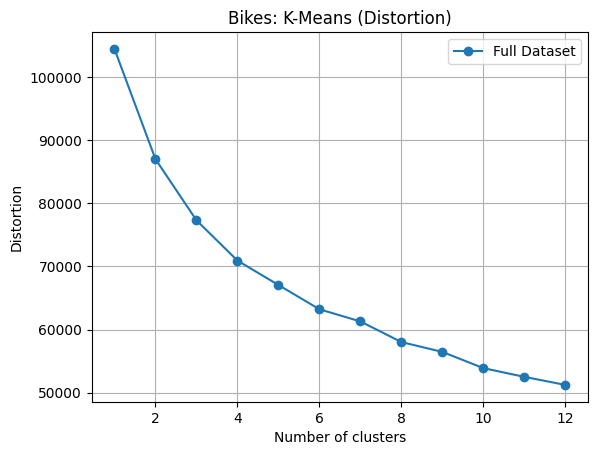

In [ ]:
plot_km("Bikes: K-Means (Distortion)", [x_train], ["Full Dataset"], k_range=range(1,13), metric="Distortion")
plt.show()

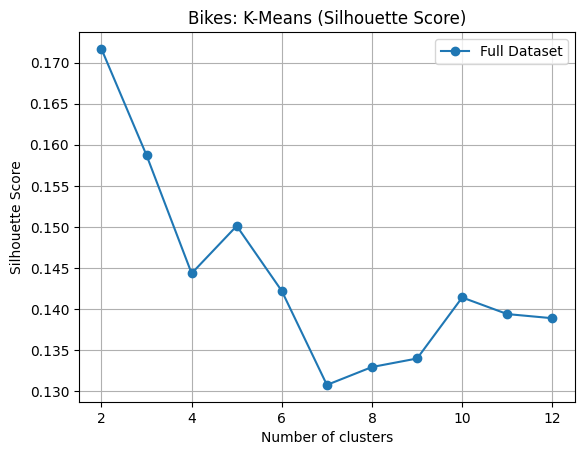

In [ ]:
plot_km("Bikes: K-Means (Silhouette Score)", [x_train],["Full Dataset"], k_range=range(2,13), metric="Silhouette Score")
plt.show()

In [22]:
km_model_2 = KMeans(n_clusters=2, n_init='auto', random_state=0)
km_model_2.fit(x_train)

km_model_5 = KMeans(n_clusters=5, n_init='auto', random_state=0)
km_model_5.fit(x_train)

km_model_10 = KMeans(n_clusters=10, n_init='auto', random_state=0)
km_model_10.fit(x_train)

km_x_train_2 = x_train.copy()
km_x_train_5 = x_train.copy()
km_x_train_10 = x_train.copy()

km_x_train_2['cluster'] = km_model_2.predict(x_train)
km_x_train_5['cluster'] = km_model_5.predict(x_train)
km_x_train_10['cluster'] = km_model_10.predict(x_train)

km_x_test_2 = x_test.copy()
km_x_test_5 = x_test.copy()
km_x_test_10 = x_test.copy()

km_x_test_2['cluster'] = km_model_2.predict(x_test)
km_x_test_5['cluster'] = km_model_5.predict(x_test)
km_x_test_10['cluster'] = km_model_10.predict(x_test)

km_test_datasets = [km_x_test_2, km_x_test_5, km_x_test_10]
km_datasets = [km_x_train_2, km_x_train_5, km_x_train_10]
km_dataset_labels = ["2 Clusters ", "5 Clusters", "10 Clusters"]

##Expectation Maximization

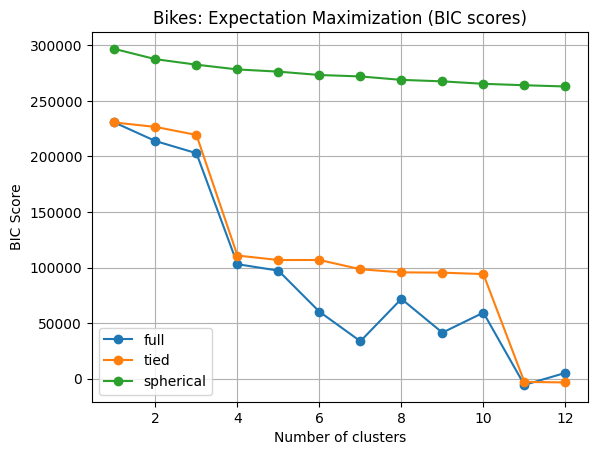

In [ ]:
plot_em_methods("Bikes: Expectation Maximization (BIC scores)", x_train, components_range=range(1,13))
plt.show()

In [ ]:
em_model_2 = GaussianMixture(n_components=2, random_state=0, covariance_type='full')
em_model_2.fit(x_train)

em_model_4 = GaussianMixture(n_components=4, random_state=0, covariance_type='full')
em_model_4.fit(x_train)

em_model_7 = GaussianMixture(n_components=7, random_state=0, covariance_type='full')
em_model_7.fit(x_train)

em_model_15 = GaussianMixture(n_components=15, random_state=0, covariance_type='full')
em_model_15.fit(x_train)

em_x_train_2 = x_train.copy()
em_x_train_4 = x_train.copy()
em_x_train_7 = x_train.copy()
em_x_train_15 = x_train.copy()

em_x_train_2['cluster'] = em_model_2.predict(x_train)
em_x_train_4['cluster'] = em_model_4.predict(x_train)
em_x_train_7['cluster'] = em_model_7.predict(x_train)
em_x_train_15['cluster'] = em_model_15.predict(x_train)

em_x_test_2 = x_test.copy()
em_x_test_4 = x_test.copy()
em_x_test_7 = x_test.copy()
em_x_test_15 = x_test.copy()

em_x_test_2['cluster'] = em_model_2.predict(x_test)
em_x_test_4['cluster'] = em_model_4.predict(x_test)
em_x_test_7['cluster'] = em_model_7.predict(x_test)
em_x_test_15['cluster'] = em_model_15.predict(x_test)

em_test_datasets = [em_x_test_2, em_x_test_4, em_x_test_7, em_x_test_15]
em_datasets = [em_x_train_2, em_x_train_4, em_x_train_7, em_x_train_15]
em_dataset_labels = ["2 Clusters ", "4 Clusters", "7 Clusters", "15 Clusters"]

#Dimentionality Reduction

## Principal Component Analysis (PCA)

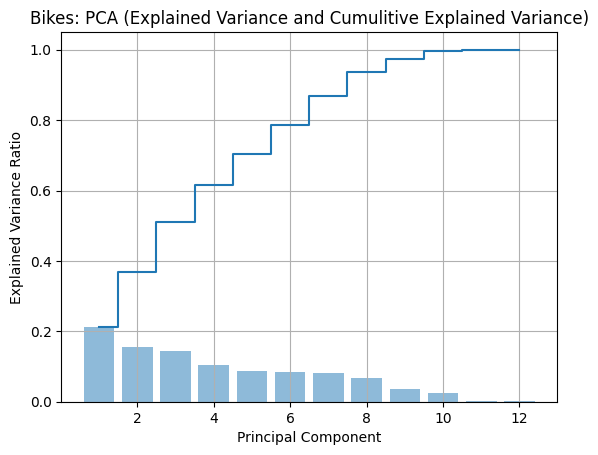

In [ ]:
plot_pca("Bikes: PCA (Explained Variance and Cumulitive Explained Variance)", x_train)
plt.show()

In [23]:
pca = PCA(n_components=12, random_state=0)
pca_x_train = pca.fit_transform(x_train)
pca_x_test = pca.transform(x_test)

pca_test_datasets = [pca_x_test[:,:3], pca_x_test[:,:5], pca_x_test[:,:9], pca_x_test[:,:11]]
pca_datasets = [pca_x_train[:,:3], pca_x_train[:,:5], pca_x_train[:,:9], pca_x_train[:,:11]]
pca_dataset_labels = ["2 Components ", "4 components", "8 components", "10 components"]

## Independent Component Analysis (ICA)

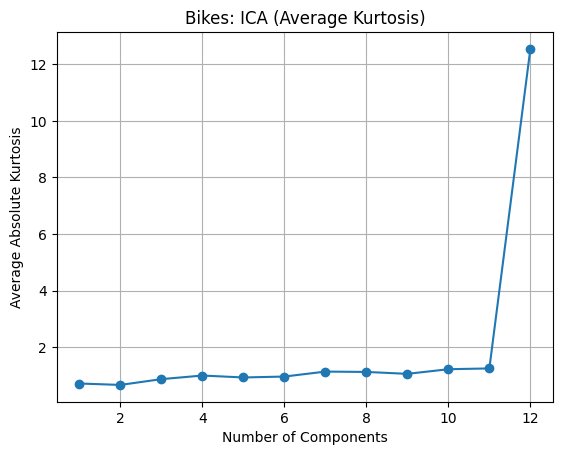

In [ ]:
plot_ica("Bikes: ICA (Average Kurtosis)", x_train)
plt.show()

In [ ]:
ica_2 = FastICA(n_components=2, whiten='unit-variance', random_state=0)
ica_5 = FastICA(n_components=5, whiten='unit-variance', random_state=0)
ica_10 = FastICA(n_components=10, whiten='unit-variance', random_state=0)

ica_x_train_2 = ica_2.fit_transform(x_train)
ica_x_train_5 = ica_5.fit_transform(x_train)
ica_x_train_10 = ica_10.fit_transform(x_train)

ica_x_test_2 = ica_2.fit_transform(x_test)
ica_x_test_5 = ica_5.fit_transform(x_test)
ica_x_test_10 = ica_10.fit_transform(x_test)

ica_test_datasets = [ica_x_test_2, ica_x_test_5, ica_x_test_10]
ica_datasets = [ica_x_train_2, ica_x_train_5, ica_x_train_10]
ica_dataset_labels = ["2 Components ", "5 components", "10 components"]

## Random Projection (RP)

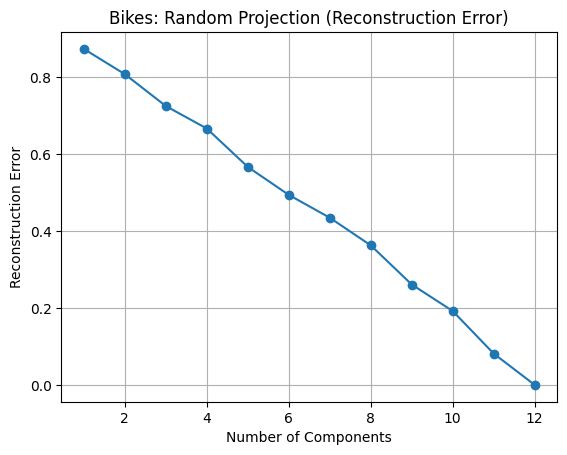

In [ ]:
plot_rp("Bikes: Random Projection (Reconstruction Error)", x_train)
plt.show()

In [ ]:
rp_2 = GaussianRandomProjection(n_components=2, random_state=0)
rp_5 = GaussianRandomProjection(n_components=5, random_state=0)
rp_10 = GaussianRandomProjection(n_components=10, random_state=0)

rp_x_train_2 = rp_2.fit_transform(x_train)
rp_x_train_5 = rp_5.fit_transform(x_train)
rp_x_train_10 = rp_10.fit_transform(x_train)

rp_x_test_2 = rp_2.fit_transform(x_test)
rp_x_test_5 = rp_5.fit_transform(x_test)
rp_x_test_10 = rp_10.fit_transform(x_test)

rp_test_datasets = [rp_x_test_2, rp_x_test_5, rp_x_test_10]
rp_datasets = [rp_x_train_2, rp_x_train_5, rp_x_train_10]
rp_dataset_labels = ["2 Components ", "5 components", "10 components"]

## Manifold Algorithm: t-SNE

In [ ]:
tsne_2 = TSNE(n_components=2, random_state=0, learning_rate='auto')
tsne_3 = TSNE(n_components=3, random_state=0, learning_rate='auto')

tsne_x_train_2 = tsne_2.fit_transform(x_train)
tsne_x_train_3 = tsne_3.fit_transform(x_train)

tsne_x_test_2 = tsne_2.fit_transform(x_test)
tsne_x_test_3 = tsne_3.fit_transform(x_test)

tsne_test_datasets = [tsne_x_test_2, tsne_x_test_3]
tsne_datasets = [tsne_x_train_2, tsne_x_train_3]
tsne_dataset_labels = ["2 Components", "3 components"]

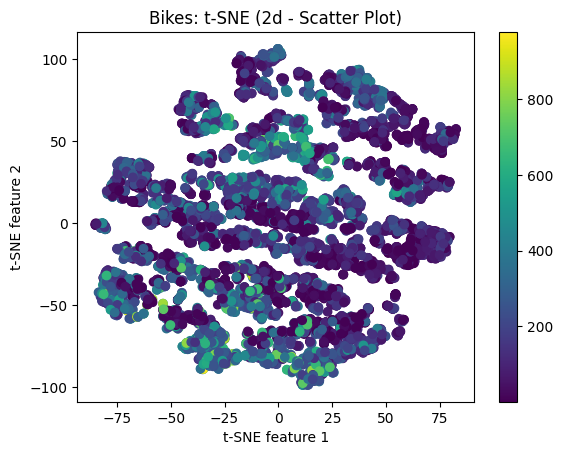

In [ ]:
plot_tsne_2d("Bikes: t-SNE (2d - Scatter Plot)", tsne_x_train_2, y_train)
plt.show()

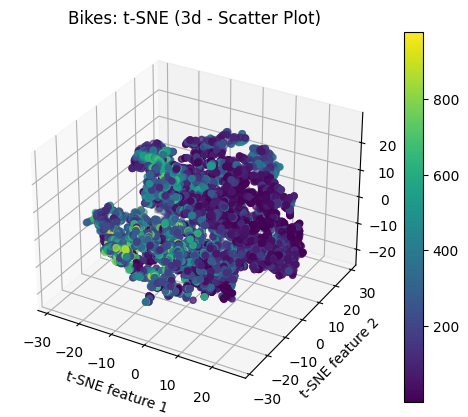

In [ ]:
plot_tsne_3d("Bikes: t-SNE (3d - Scatter Plot)", tsne_x_train_3, y_train)
plt.show()

# Clustering - Dimentions Reduced

##K-Means

### Principal Component Analysis (PCA)

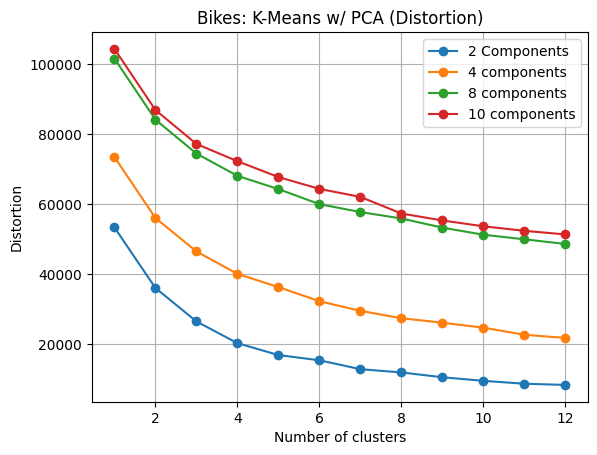

In [ ]:
plot_km("Bikes: K-Means w/ PCA (Distortion)", pca_datasets, pca_dataset_labels, k_range=range(1,13), metric="Distortion")
plt.show()

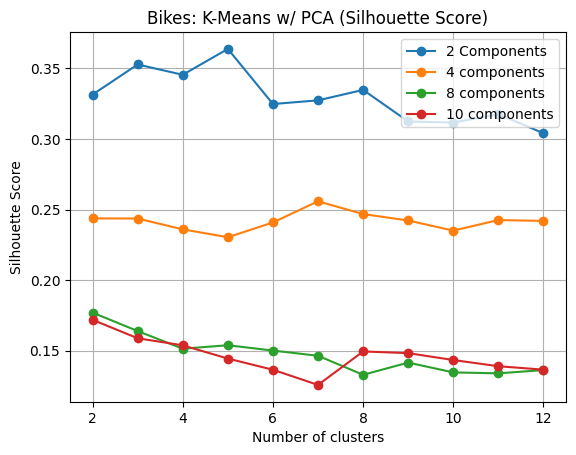

In [ ]:
plot_km("Bikes: K-Means w/ PCA (Silhouette Score)", pca_datasets, pca_dataset_labels, k_range=range(2,13), metric="Silhouette Score")
plt.show()

### Independent Component Analysis (ICA)

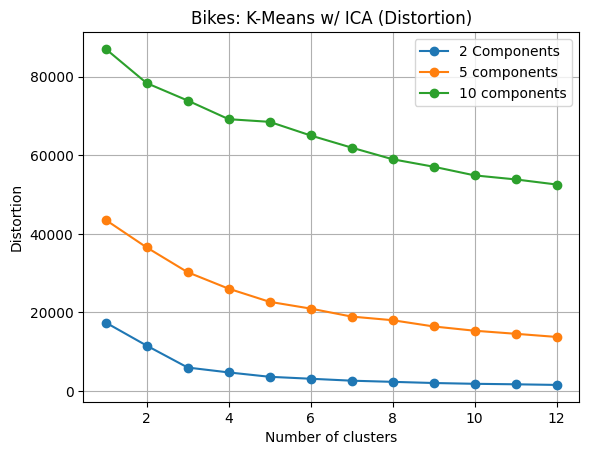

In [ ]:
plot_km("Bikes: K-Means w/ ICA (Distortion)", ica_datasets, ica_dataset_labels, k_range=range(1,13), metric="Distortion")
plt.show()

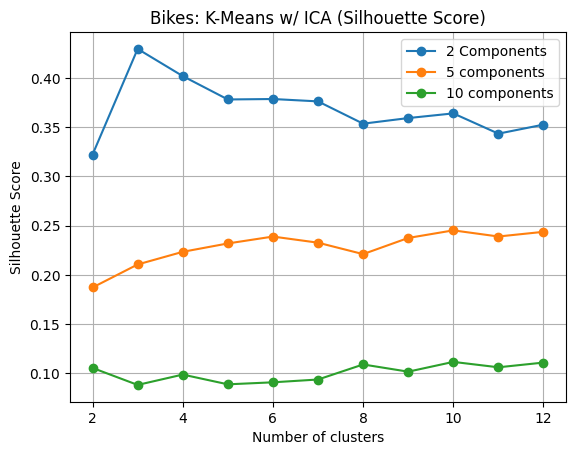

In [ ]:
plot_km("Bikes: K-Means w/ ICA (Silhouette Score)", ica_datasets, ica_dataset_labels, k_range=range(2,13), metric="Silhouette Score")
plt.show()

### Random Projection (RP)

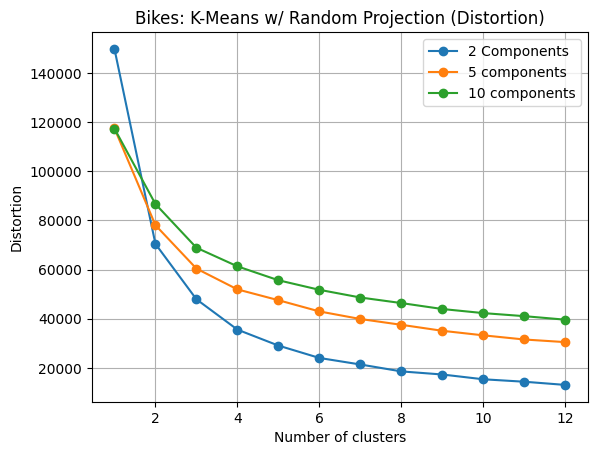

In [ ]:
plot_km("Bikes: K-Means w/ Random Projection (Distortion)", rp_datasets, rp_dataset_labels, k_range=range(1,13), metric="Distortion")
plt.show()

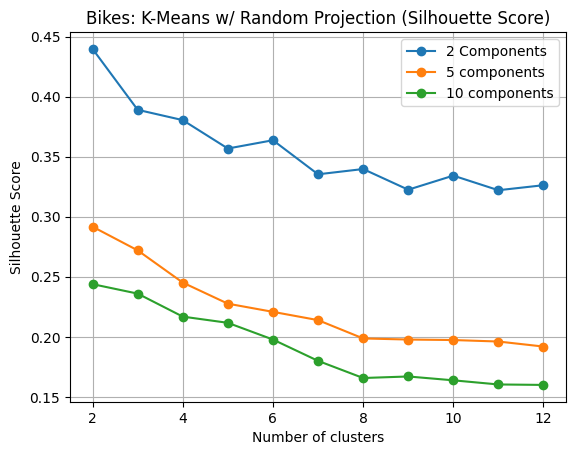

In [ ]:
plot_km("Bikes: K-Means w/ Random Projection (Silhouette Score)", rp_datasets, rp_dataset_labels, k_range=range(2,13), metric="Silhouette Score")
plt.show()

### Manifold Algorithm: t-SNE

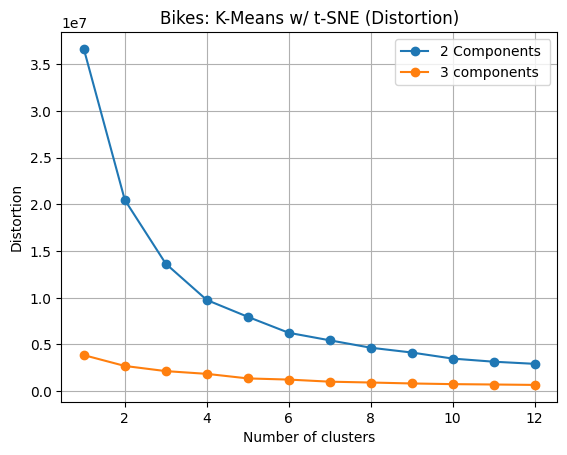

In [ ]:
plot_km("Bikes: K-Means w/ t-SNE (Distortion)", tsne_datasets, tsne_dataset_labels, k_range=range(1,13), metric="Distortion")
plt.show()

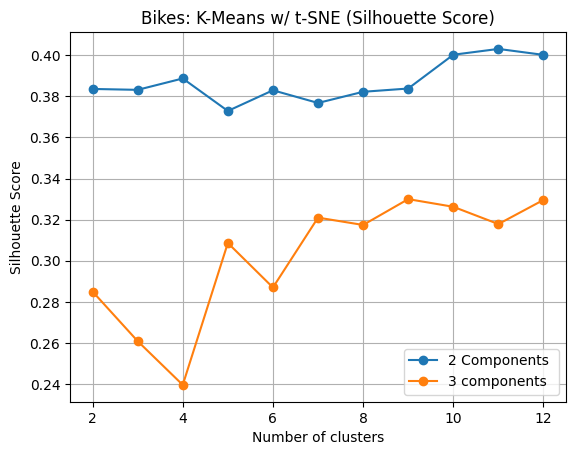

In [ ]:
plot_km("Bikes: K-Means w/ t-SNE (Silhouette Score)", tsne_datasets, tsne_dataset_labels, k_range=range(2,13), metric="Silhouette Score")
plt.show()

##Expectation Maximization

### Principal Component Analysis (PCA)

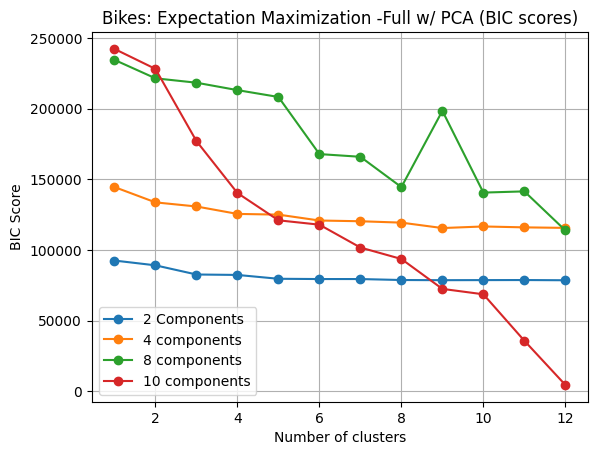

In [ ]:
plot_em("Bikes: Expectation Maximization -Full w/ PCA (BIC scores)", pca_datasets, pca_dataset_labels, components_range=range(1,13))
plt.show()

### Independent Component Analysis (ICA)

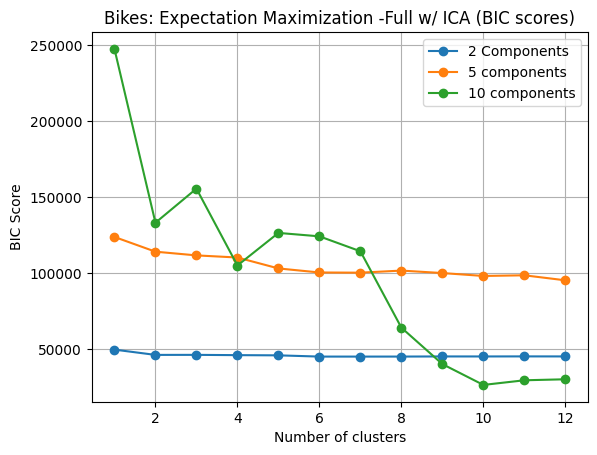

In [ ]:
plot_em("Bikes: Expectation Maximization -Full w/ ICA (BIC scores)", ica_datasets, ica_dataset_labels, components_range=range(1,13))
plt.show()

### Random Projection (RP)

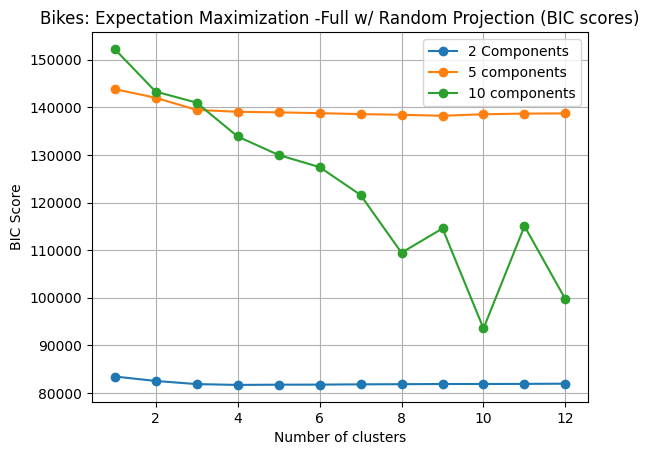

In [ ]:
plot_em("Bikes: Expectation Maximization -Full w/ Random Projection (BIC scores)", rp_datasets, rp_dataset_labels, components_range=range(1,13))
plt.show()

### Manifold Algorithm: t-SNE

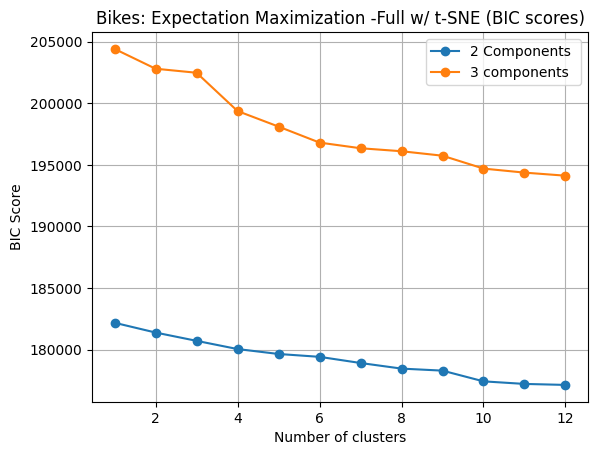

In [ ]:
plot_em("Bikes: Expectation Maximization -Full w/ t-SNE (BIC scores)", tsne_datasets, tsne_dataset_labels, components_range=range(1,13))
plt.show()

#Neural Network


## After Dimentionality Reduction

### Principal Component Analysis (PCA)

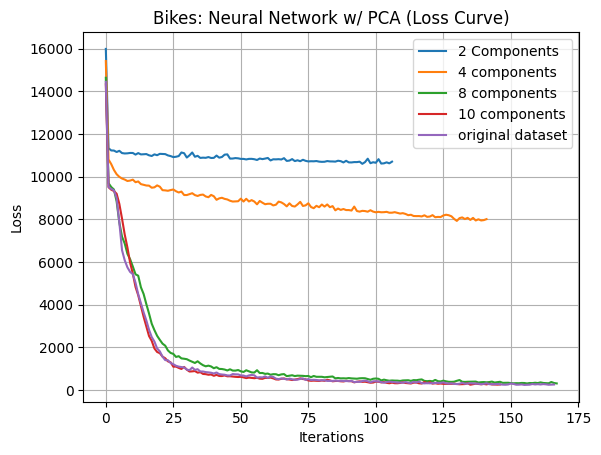

In [ ]:
plot_loss_curve("Bikes: Neural Network w/ PCA (Loss Curve)", pca_datasets+[x_train], pca_dataset_labels+["original dataset"], y_train)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

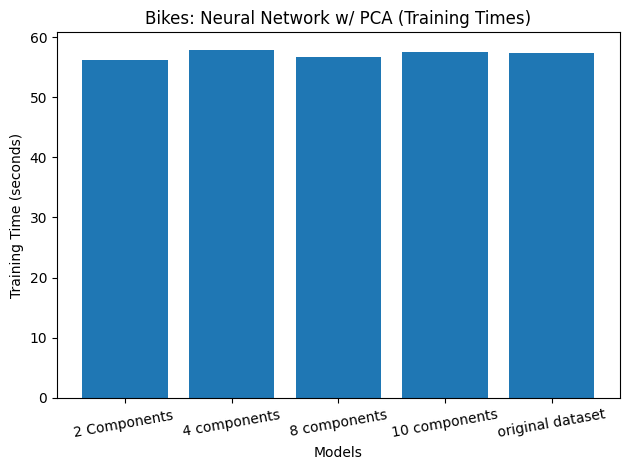

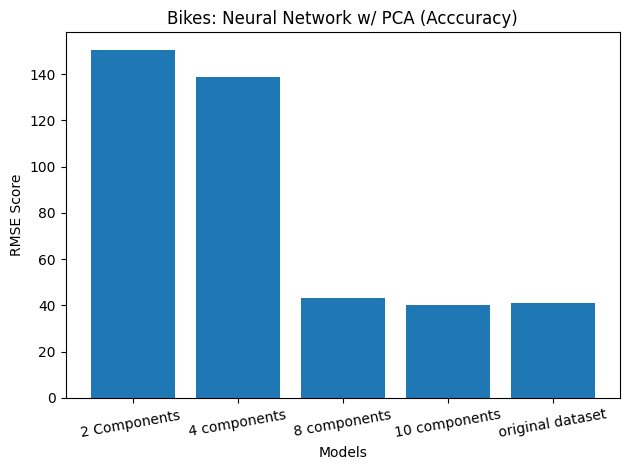

In [ ]:
compare_models("Bikes: Neural Network w/ PCA (Training Times)", "Bikes: Neural Network w/ PCA (Acccuracy)", pca_datasets+[x_train], pca_test_datasets+[x_test], pca_dataset_labels+["original dataset"], y_train, y_test)

### Independent Component Analysis (ICA)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


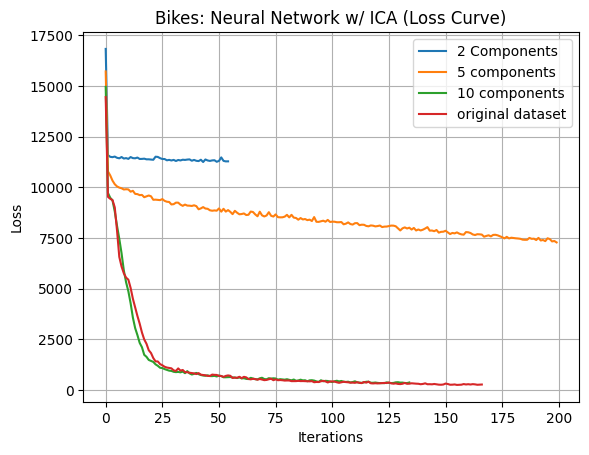

In [ ]:
plot_loss_curve("Bikes: Neural Network w/ ICA (Loss Curve)", ica_datasets+[x_train], ica_dataset_labels+["original dataset"], y_train)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


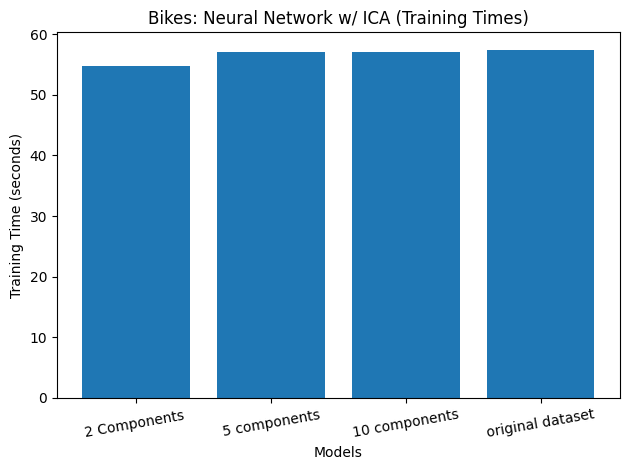

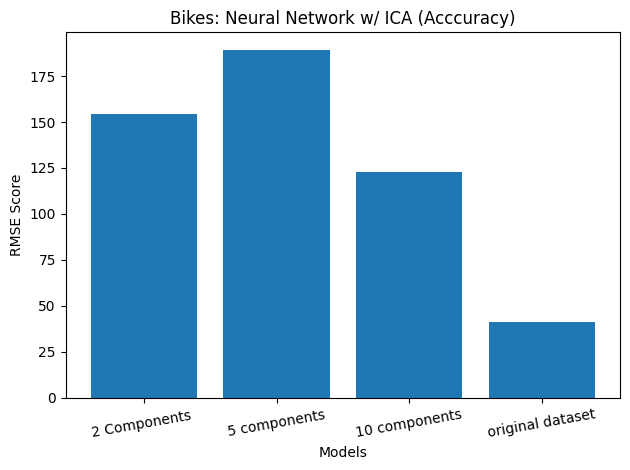

In [ ]:
compare_models("Bikes: Neural Network w/ ICA (Training Times)", "Bikes: Neural Network w/ ICA (Acccuracy)", ica_datasets+[x_train], ica_test_datasets+[x_test], ica_dataset_labels+["original dataset"], y_train, y_test)

### Random Projection (RP)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


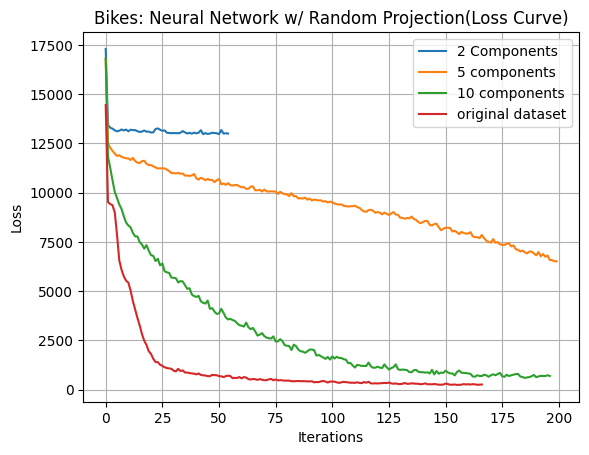

In [ ]:
plot_loss_curve("Bikes: Neural Network w/ Random Projection(Loss Curve)", rp_datasets+[x_train], rp_dataset_labels+["original dataset"], y_train)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


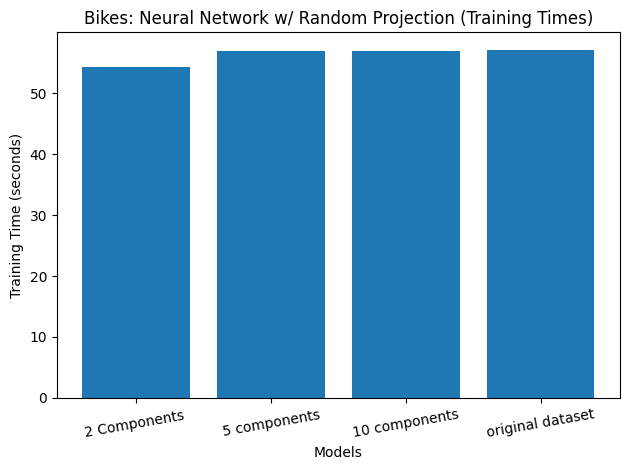

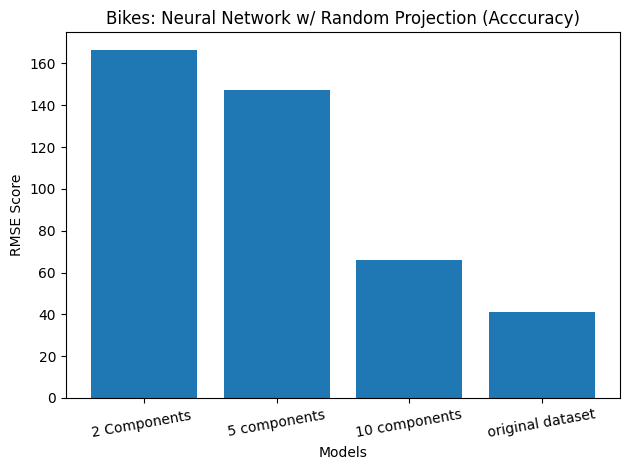

In [ ]:
compare_models("Bikes: Neural Network w/ Random Projection (Training Times)", "Bikes: Neural Network w/ Random Projection (Acccuracy)", rp_datasets+[x_train], rp_test_datasets+[x_test], rp_dataset_labels+["original dataset"], y_train, y_test)

### Manifold Algorithm: t-SNE

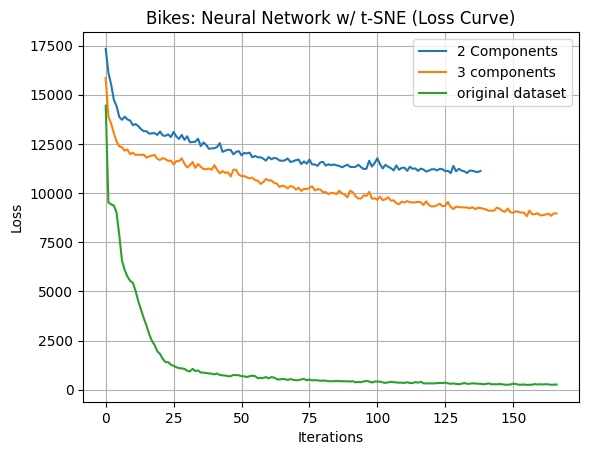

In [ ]:
plot_loss_curve("Bikes: Neural Network w/ t-SNE (Loss Curve)", tsne_datasets+[x_train], tsne_dataset_labels+["original dataset"], y_train)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


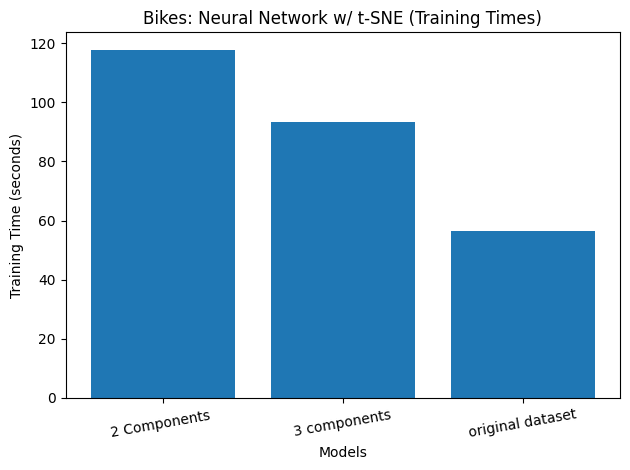

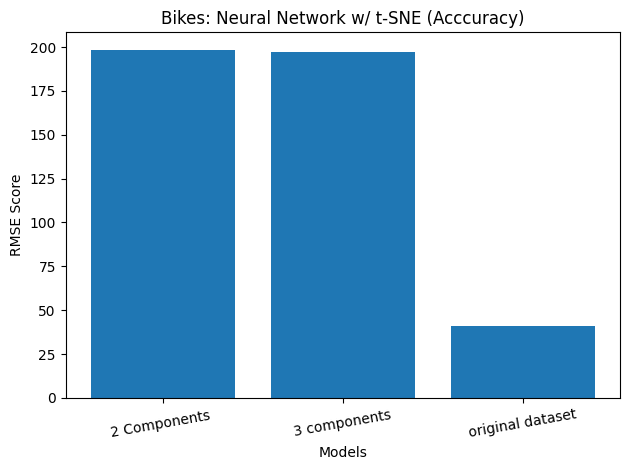

In [ ]:
compare_models("Bikes: Neural Network w/ t-SNE (Training Times)", "Bikes: Neural Network w/ t-SNE (Acccuracy)", tsne_datasets+[x_train], tsne_test_datasets+[x_test], tsne_dataset_labels+["original dataset"], y_train, y_test)

## With Clustering Info

### K-means

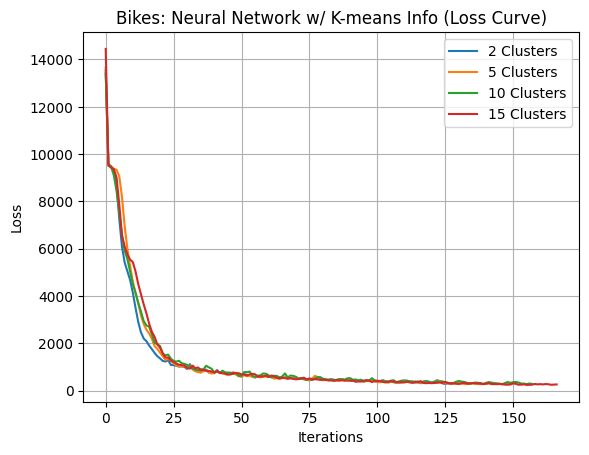

In [ ]:
plot_loss_curve("Bikes: Neural Network w/ K-means Info (Loss Curve)", km_datasets+[x_train], km_dataset_labels+["original dataset"], y_train)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


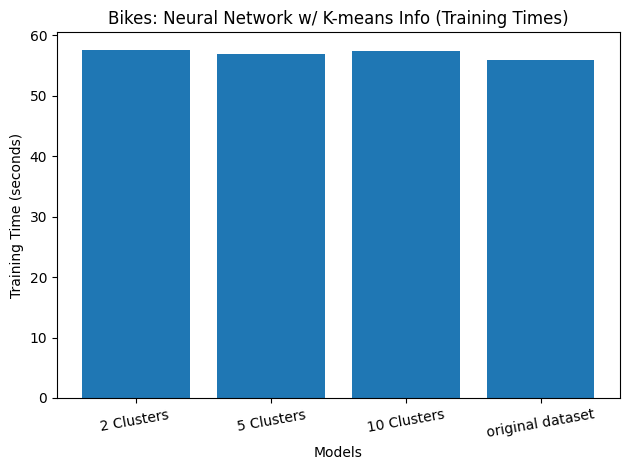

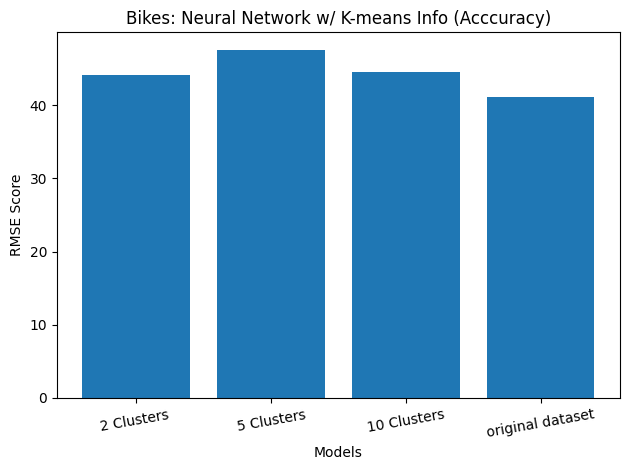

In [ ]:
compare_models("Bikes: Neural Network w/ K-means Info (Training Times)", "Bikes: Neural Network w/ K-means Info (Acccuracy)", km_datasets+[x_train], km_test_datasets+[x_test], km_dataset_labels+["original dataset"], y_train, y_test)

### Expectation Maximization

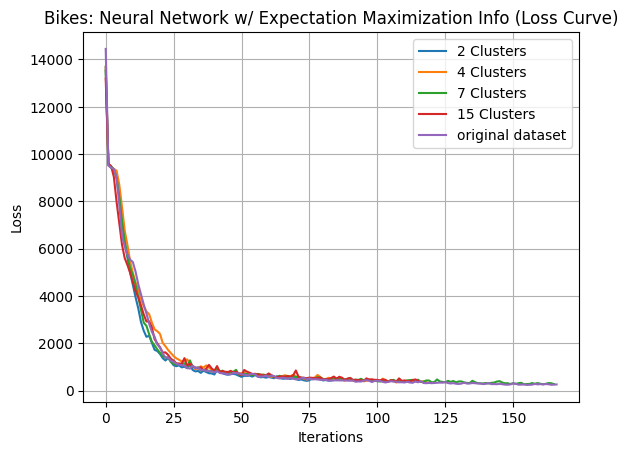

In [ ]:
plot_loss_curve("Bikes: Neural Network w/ Expectation Maximization Info (Loss Curve)", em_datasets+[x_train], em_dataset_labels+["original dataset"], y_train)
plt.show()

In [ ]:
compare_models("Bikes: Neural Network w/ Expectation Maximization Info (Training Times)", "Bikes: Neural Network w/ Expectation Maximization Info (Acccuracy)", em_datasets+[x_train], em_test_datasets+[x_test], em_dataset_labels+["original dataset"], y_train, y_test)

# Model Comparisons

In [33]:
km_pca_test_datasets = [pca_x_test[:,:3].copy(), pca_x_test[:,:6].copy(), pca_x_test[:,:11].copy()]
km_pca_datasets = [pca_x_train[:,:3].copy(), pca_x_train[:,:6].copy(), pca_x_train[:,:11].copy()]
km_pca_dataset_labels = ["2 Components ", "5 components", "10 components"]

km_pca_test_datasets[0] = np.append(km_pca_test_datasets[0], np.reshape(km_x_test_10['cluster'].to_numpy(), newshape=(2178 ,-1)), axis=1)
km_pca_test_datasets[1] = np.append(km_pca_test_datasets[1], np.reshape(km_x_test_10['cluster'].to_numpy(), newshape=(2178 ,-1)), axis=1)
km_pca_test_datasets[2] = np.append(km_pca_test_datasets[2], np.reshape(km_x_test_10['cluster'].to_numpy(), newshape=(2178 ,-1)), axis=1)


km_pca_datasets[0] = np.append(km_pca_datasets[0], np.reshape(km_x_train_10['cluster'].to_numpy(), newshape=(8708 ,-1)), axis=1)
km_pca_datasets[1] = np.append(km_pca_datasets[1], np.reshape(km_x_train_10['cluster'].to_numpy(), newshape=(8708 ,-1)), axis=1)
km_pca_datasets[2] = np.append(km_pca_datasets[2], np.reshape(km_x_train_10['cluster'].to_numpy(), newshape=(8708 ,-1)), axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


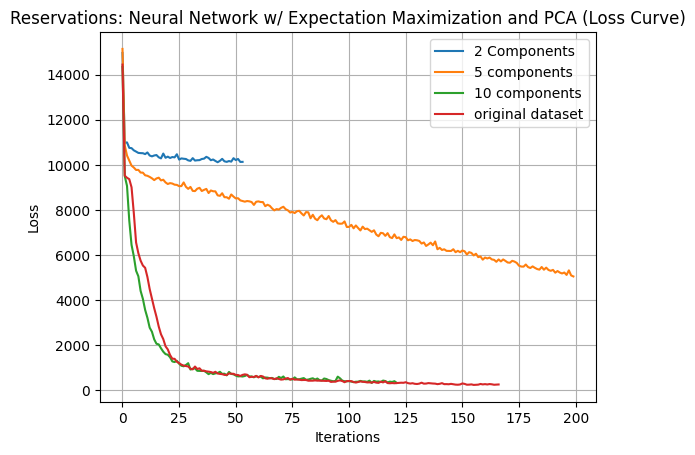

In [34]:
plot_loss_curve("Reservations: Neural Network w/ Expectation Maximization and PCA (Loss Curve)", km_pca_datasets+[x_train], km_pca_dataset_labels+["original dataset"], y_train)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


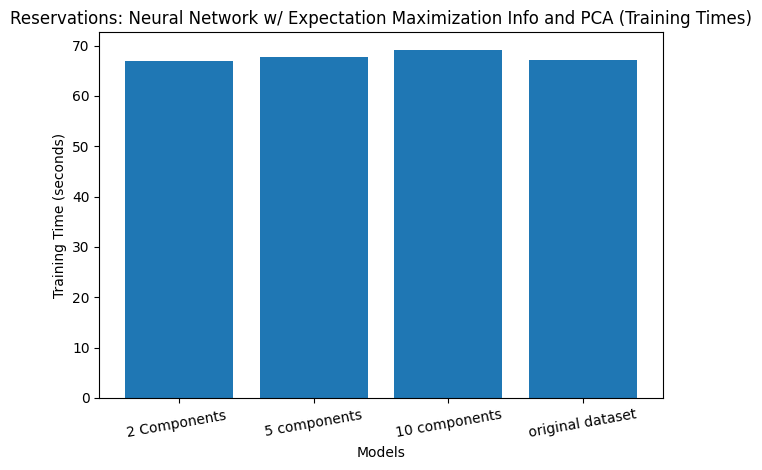

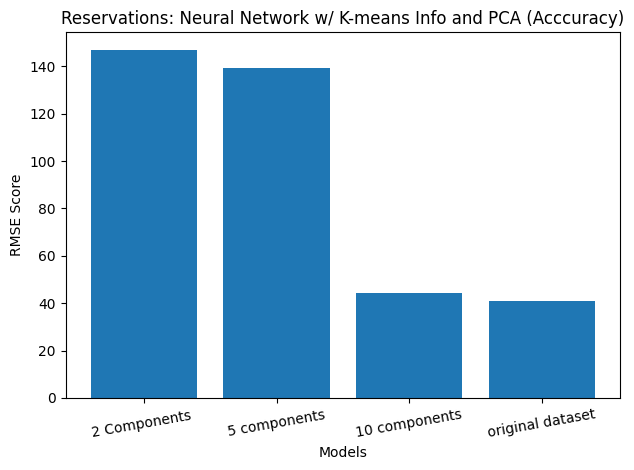

In [35]:
compare_models("Reservations: Neural Network w/ Expectation Maximization Info and PCA (Training Times)", "Reservations: Neural Network w/ K-means Info and PCA (Acccuracy)", km_pca_datasets+[x_train], km_pca_test_datasets+[x_test], km_pca_dataset_labels+["original dataset"], y_train, y_test)